# Revenue Forecasting (Linear Regression)

## Load libraries and data

In [1]:
import io
import requests
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib as mpl
import matplotlib.pyplot as plt

# Do not use scientific notation in pandas tables
pd.options.display.float_format = '{:,.2f}'.format

# Plot formatting
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Data Description

When retailers close stores, they usually conduct going-out-of-business (GOB) sales.

In the data set, each row represents a store's going out of business sale.

| Attribute             | Definition                                                                |
| --------------------- | ------------------------------------------------------------------------- |
| StoreType             | Store's retail segment (bookstores or household goods)                    |
| LiquidationRevenue    | Revenue from the GOB sale                                                 |
| InventoryAtTicket     | Retail value of inventory held at the start of the GOB sale               |
| LastYearRevenue       | Store's revenue over the GOB sale dates during the prior year             |                      
| MedianHouseholdIncome | Median household income in the store's ZIP code (from U.S. Census Bureau) |
| MedianAge             | Median age in the store's ZIP code (from U.S. Census Bureau)              |


In [2]:
url = 'https://raw.githubusercontent.com/natecraig/aiml/main/Data/closings.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head()

,StoreType,LiquidationRevenue,InventoryAtTicket,LastYearRevenue,MedianHouseholdIncome,MedianAge
0,Bookstore,"1,214,776.20","2,195,069.80","465,237.30",51290,37.80
1,Bookstore,"1,811,896.90","3,152,301.90","897,704.50",46702,33.40
2,Bookstore,"1,157,614.70","2,229,837.50","477,804.80",86804,41.70
3,Bookstore,"2,037,136.20","3,857,466.80","1,036,097.70",83544,40.30
4,Bookstore,"1,326,821.10","2,345,263.80","612,793.50",23508,31.90


In [3]:
df.describe()

,LiquidationRevenue,InventoryAtTicket,LastYearRevenue,MedianHouseholdIncome,MedianAge
count,563.00,563.00,563.00,563.00,563.00
mean,"1,760,173.72","2,577,544.48","1,199,333.24","56,434.49",35.46
std,"627,458.30","615,848.68","676,114.87","19,169.46",5.15
min,"387,896.74","880,019.80","190,021.70","5,903.00",20.40
25%,"1,180,383.60","2,211,686.01","519,235.75","42,884.00",32.60
50%,"1,801,890.20","2,638,186.98","1,238,979.50","53,315.00",35.20
75%,"2,180,334.20","2,963,110.04","1,598,852.20","67,564.50",37.90
max,"4,479,299.00","5,018,391.40","4,194,362.70","144,257.00",64.30


In [4]:
# Create a correlation matrix
df.corr()

,LiquidationRevenue,InventoryAtTicket,LastYearRevenue,MedianHouseholdIncome,MedianAge
LiquidationRevenue,1.00,0.87,0.94,0.06,0.06
InventoryAtTicket,0.87,1.00,0.82,0.06,0.12
LastYearRevenue,0.94,0.82,1.00,0.05,0.14
MedianHouseholdIncome,0.06,0.06,0.05,1.00,0.21
MedianAge,0.06,0.12,0.14,0.21,1.00


In [5]:
# Count household goods stores and bookstores
df['StoreType'].value_counts()

Household Goods    366
Bookstore          197
Name: StoreType, dtype: int64

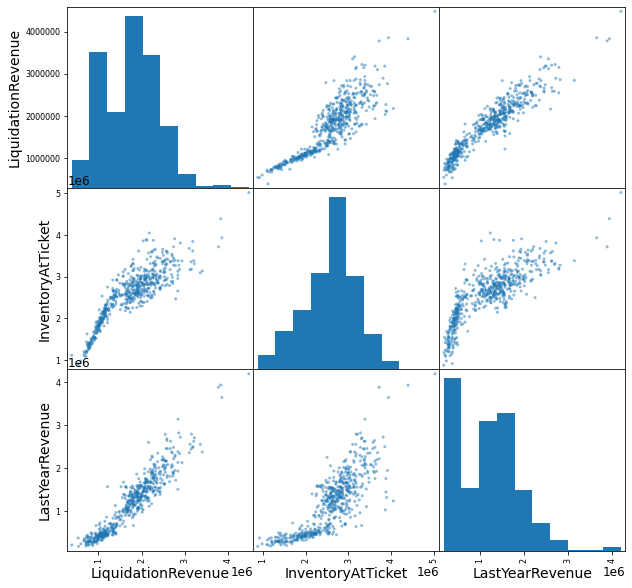

In [6]:
# Use scatter_matrix from pandas to visualize
scatter_matrix(df[['LiquidationRevenue', 'InventoryAtTicket', 'LastYearRevenue']],
               figsize=(10, 10))
plt.show()

### Exercise
How much inventory does the average bookstore hold? The average household goods store?

What is the mean recovery rate (ratio of revenue from liquidation to inventory value) for bookstores? For household goods stores?

## Bookstore Model

In [4]:
# Create a data subset containing only bookstores
df_book = df[df['StoreType'] == 'Bookstore']

### Visualizing Relationships with Liquidation Revenue

[Text(0, 0.5, 'Liquidation Revenue')]

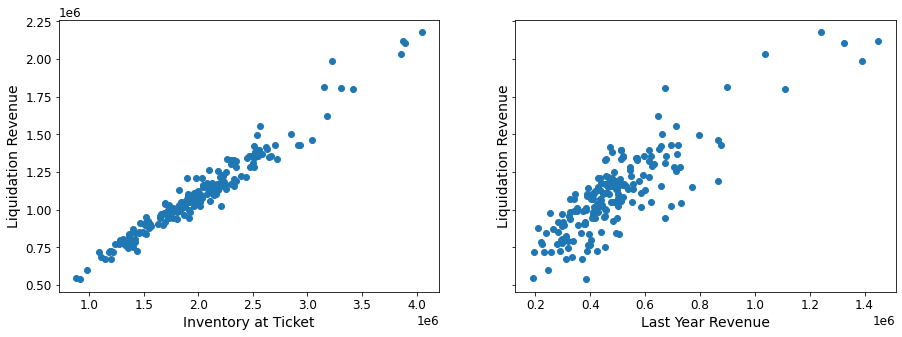

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax[0].scatter('InventoryAtTicket', 'LiquidationRevenue', data=df_book)
ax[0].set(xlabel='Inventory at Ticket')
ax[0].set(ylabel='Liquidation Revenue')

ax[1].scatter('LastYearRevenue', 'LiquidationRevenue', data=df_book)
ax[1].set(xlabel='Last Year Revenue')
ax[1].set(ylabel='Liquidation Revenue')

### Exercise
Add plots for MedianHouseholdIncome and MedianAge to the visualization.

### Fit Models of LiquidationRevenue

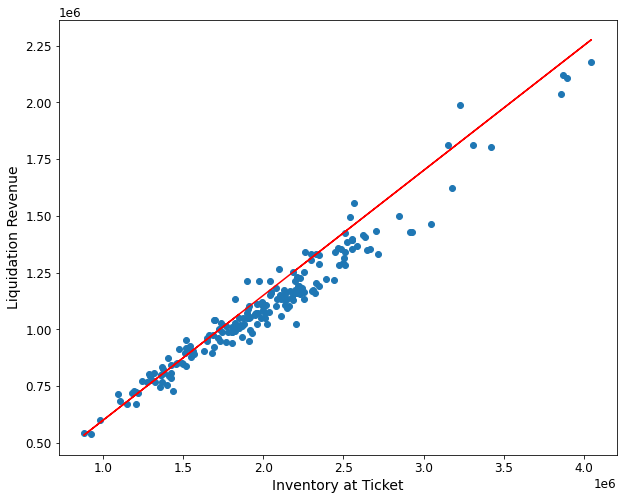

In [11]:
# Let's try an arbitrary linear model for the
# relationship between LiquidationRevenue and InventoryAtTicket

# Suppose the model is LiquidationRevenue = 10,000 + 0.7*InventoryAtTicket

# Visualize our model
y_pred = 50000 + 0.55*df_book['InventoryAtTicket']

plt.subplots(figsize=(10, 8))
plt.scatter(df_book['InventoryAtTicket'], df_book['LiquidationRevenue'])
plt.plot(df_book['InventoryAtTicket'], y_pred, color='red')
plt.xlabel('Inventory at Ticket')
plt.ylabel('Liquidation Revenue')
plt.show()

# Visually, it is clear that we could come up
# with a model that better fits the data!

In [12]:
# Let's calculate optimal parameters according to the normal equation

# These parameters minimize the mean squared error (MSE) of the outcomes

y = df_book['LiquidationRevenue']

# Create X matrix containing a column of 1s for the bias term
m = df_book.shape[0]
X = np.column_stack([np.ones([m, 1]), df_book['InventoryAtTicket']])

# Output first 5 rows of the X matrix
print(X[0:5, :])

# Apply the normal equation
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print(f'\nParameters: {theta_best}')

[[1.0000000e+00 2.1950698e+06]
 [1.0000000e+00 3.1523019e+06]
 [1.0000000e+00 2.2298375e+06]
 [1.0000000e+00 3.8574668e+06]
 [1.0000000e+00 2.3452638e+06]]

Parameters: [1.19844857e+05 4.90507349e-01]


In [13]:
# Calculate optimal parameters using scikit-learn
lin_reg = LinearRegression()

# scikit-learn automatically handle the bias term,
# so we do not need to the column of 1s to the X matrix
X = df_book[['InventoryAtTicket']]
lin_reg.fit(X, y)

print(f'Bias term: {lin_reg.intercept_}\n'
      f'Inventory coefficient: {lin_reg.coef_[0]}')

# Calculate predictions for the training data
y_pred = lin_reg.predict(X)

Bias term: 119844.85730796459
Inventory coefficient: 0.4905073490147603


In [12]:
# Calculate MSE and RMSE
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f'MSE:  {mse:.3f}\n'
      f'RMSE: {rmse:.3f}')

MSE:  3532638761.718
RMSE: 59436.006


In [13]:
# Calculate R^2
r2_score(y, y_pred)

0.9535376270290065

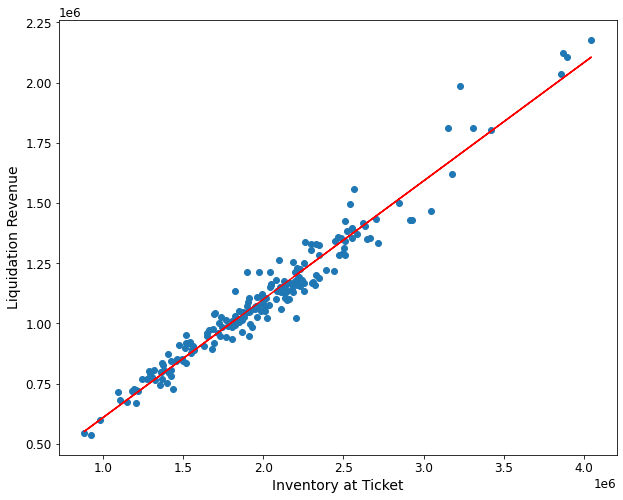

In [14]:
# Visualize the model's predictions
plt.subplots(figsize=(10, 8))
plt.scatter(df_book['InventoryAtTicket'], df_book['LiquidationRevenue'])
plt.plot(df_book['InventoryAtTicket'], y_pred, color='red')
plt.xlabel('Inventory at Ticket')
plt.ylabel('Liquidation Revenue')
plt.show()

### Exercise
Fit a model of LiquidationRevenue as a function of InventoryAtTicket and LastYearRevenue. How do MSE and R<sup>2</sup> change as you add features?

In [17]:
# Calculate optimal parameters using scikit-learn
lin_reg = LinearRegression()

# scikit-learn automatically handle the bias term,
# so we do not need to the column of 1s to the X matrix
X = df_book[['InventoryAtTicket', 'LastYearRevenue']]
lin_reg.fit(X, y)

print(f'Bias term: {lin_reg.intercept_}\n'
      f'Inventory coefficient: {lin_reg.coef_[0]}\n'
      f'LastYearRevenue coefficient: {lin_reg.coef_[1]}')

# Calculate predictions for the training data
y_pred = lin_reg.predict(X)

Bias term: 137603.27144271345
Inventory coefficient: 0.4403235231597482
LastYearRevenue coefficient: 0.1692736859119611


In [19]:
X

,InventoryAtTicket,LastYearRevenue
0,"2,195,069.80","465,237.30"
1,"3,152,301.90","897,704.50"
2,"2,229,837.50","477,804.80"
3,"3,857,466.80","1,036,097.70"
4,"2,345,263.80","612,793.50"
...,...,...
192,"920,683.50","383,519.40"
193,"1,691,976.00","381,279.80"
194,"1,735,036.60","434,416.40"
195,"1,518,529.10","451,317.90"


In [15]:
lin_reg.coef_

array([0.44032352, 0.16927369])

In [18]:
# Calculate R^2
r2_score(y, y_pred)

0.9578746650076732

## Nonlinear Relationships: Categorical and Interaction Variables

In [21]:
# To bring in store type, we need to encode
# the categorical variable StoreType
df['Bookstore'] = df['StoreType'].apply(lambda x: 1 if x == 'Bookstore' else 0)

In [22]:
# Fit a model of liquidation revenue as a function of store type and inventory
y = df['LiquidationRevenue']
X = df[['Bookstore', 'InventoryAtTicket']]

lin_reg = LinearRegression()
lin_reg.fit(X, y)

y_pred = lin_reg.predict(X)

print(f'Bias term: {lin_reg.intercept_}\n'
      f'Coefficients: {lin_reg.coef_}')

Bias term: 215238.34977209242
Coefficients: [-4.32236527e+05  6.58060328e-01]


In [23]:
# Calculate MSE, RMSE, and R^2
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print(f'MSE:  {mse:.3f}\n'
      f'RMSE: {rmse:.3f}\n'
      f'R^2:  {r2:.3f}')

MSE:  73657722541.849
RMSE: 271399.563
R^2:  0.813


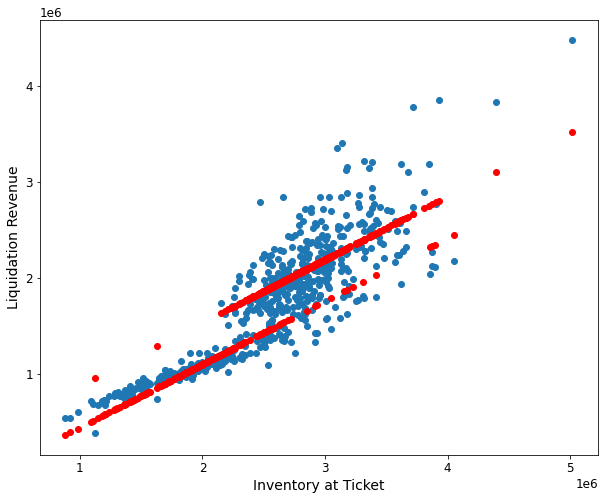

In [24]:
# Visualize the model's predictions in the space of inventory and revenue
plt.subplots(figsize=(10, 8))
plt.scatter(df['InventoryAtTicket'], df['LiquidationRevenue'])
plt.scatter(df['InventoryAtTicket'], y_pred, color='red')
plt.xlabel('Inventory at Ticket')
plt.ylabel('Liquidation Revenue')
plt.show()

In [25]:
# Add an interaction variable between store type and inventory
df['BookstoreXInventoryAtTicket'] = df['Bookstore'] * df['InventoryAtTicket']

y = df['LiquidationRevenue']
X = df[['Bookstore', 'InventoryAtTicket', 'BookstoreXInventoryAtTicket']]

lin_reg = LinearRegression()
lin_reg.fit(X, y)

y_pred = lin_reg.predict(X)

print(f'Bias term: {lin_reg.intercept_}\n'
      f'Coefficients: {lin_reg.coef_}')

Bias term: -294027.66853888286
Coefficients: [ 4.13872526e+05  8.34715319e-01 -3.44207970e-01]


In [26]:
# Calculate MSE, RMSE, and R^2
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print(f'MSE:  {mse:.3f}\n'
      f'RMSE: {rmse:.3f}\n'
      f'R^2:  {r2:.3f}')

MSE:  67576714925.915
RMSE: 259955.217
R^2:  0.828


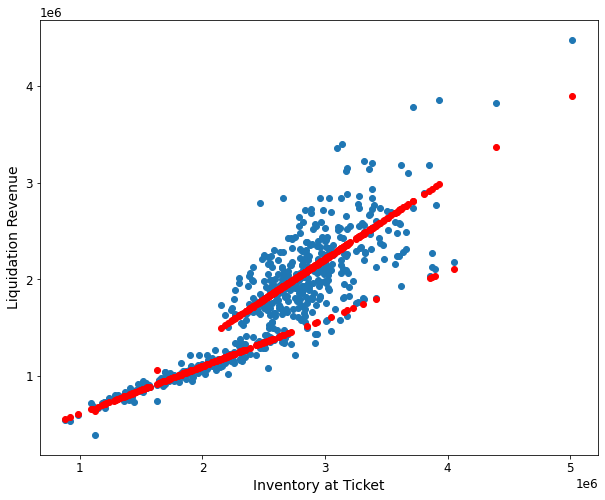

In [21]:
# Visualize the model's predictions in the space of inventory and revenue
plt.subplots(figsize=(10, 8))
plt.scatter(df['InventoryAtTicket'], df['LiquidationRevenue'])
plt.scatter(df['InventoryAtTicket'], y_pred, color='red')
plt.xlabel('Inventory at Ticket')
plt.ylabel('Liquidation Revenue')
plt.show()

## Incorporating More Features

In [22]:
# Fit a model that includes LastYearRevenue as well as the features from the prior model
y = df['LiquidationRevenue']
X = df[['Bookstore', 'InventoryAtTicket', 'BookstoreXInventoryAtTicket',
        'LastYearRevenue']]

lin_reg = LinearRegression()
lin_reg.fit(X, y)

y_pred = lin_reg.predict(X)

print(f'Bias term: {lin_reg.intercept_}\n'
      f'Coefficients: {lin_reg.coef_}')

Bias term: 436502.6183130762
Coefficients: [-2.49526880e+05  2.30479042e-01  7.03219273e-02  6.39893383e-01]


In [23]:
# Calculate MSE, RMSE, and R^2
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)
print(f'MSE:  {mse:.3f}\n'
      f'RMSE: {rmse:.3f}\n'
      f'R^2:  {r2:.3f}')

MSE:  31587741799.462
RMSE: 177729.406
R^2:  0.920


### Exercise
How might you improve the model?